In [1]:
import nltk
import pandas as pd
import numpy as np
import re

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Arini
[nltk_data]     Suryadi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Arini
[nltk_data]     Suryadi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
train_data = pd.read_csv('train_preprocess.tsv', sep='\t', header=None, names=['text', 'label'])
test_data = pd.read_csv('test_preprocess.tsv', sep='\t', header=None, names=['text', 'label'])
val_data = pd.read_csv('valid_preprocess.tsv', sep='\t', header=None, names=['text', 'label'])

train_data.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [4]:
train_data['label'].value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

In [5]:
# Encode label
train_data['label'] = train_data['label'].map({'positive': 1, 'negative': 0, 'neutral': 2})
test_data['label'] = test_data['label'].map({'positive': 1, 'negative': 0, 'neutral': 2})
val_data['label'] = val_data['label'].map({'positive': 1, 'negative': 0, 'neutral': 2})

In [6]:
## Preprocessing Data

# lowercasing
train_data['text'] = train_data['text'].str.lower()
test_data['text'] = test_data['text'].str.lower()
val_data['text'] = val_data['text'].str.lower()

# tokenization
train_data['tokenized_text'] = train_data['text'].apply(nltk.word_tokenize)
test_data['tokenized_text'] = test_data['text'].apply(nltk.word_tokenize)
val_data['tokenized_text'] = val_data['text'].apply(nltk.word_tokenize)

# remove stopwords
stopwords = set(nltk.corpus.stopwords.words('indonesian'))
train_data['rem_stopwords_text'] = train_data['tokenized_text'].apply(lambda x: [word for word in x if word not in stopwords])
test_data['rem_stopwords_text'] = test_data['tokenized_text'].apply(lambda x: [word for word in x if word not in stopwords])
val_data['rem_stopwords_text'] = val_data['tokenized_text'].apply(lambda x: [word for word in x if word not in stopwords])

# stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()
train_data['stemmed_text'] = train_data['rem_stopwords_text'].apply(lambda x: [stemmer.stem(word) for word in x])
test_data['stemmed_text'] = test_data['rem_stopwords_text'].apply(lambda x: [stemmer.stem(word) for word in x])
val_data['stemmed_text'] = val_data['rem_stopwords_text'].apply(lambda x: [stemmer.stem(word) for word in x])

# Merge tokenized text
train_data['merged_text'] = train_data['stemmed_text'].apply(lambda x: ' '.join(x))
test_data['merged_text'] = test_data['stemmed_text'].apply(lambda x: ' '.join(x))
val_data['merged_text'] = val_data['stemmed_text'].apply(lambda x: ' '.join(x))


In [7]:
## Feature Extraction

# Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data['merged_text'])
X_test = vectorizer.transform(test_data['merged_text'])
X_val = vectorizer.transform(val_data['merged_text'])

y_train = train_data['label']
y_test = test_data['label']
y_val = val_data['label']

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
def check_result(y_test,y_pred):
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, average='weighted'))
    print('Recall:', recall_score(y_test, y_pred, average='weighted'))
    print('F1 Score:', f1_score(y_test, y_pred, average='weighted'))

    print(classification_report(y_test, y_pred))

In [11]:
## Model Training

# Logistic Regression
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)

check_result(y_test, y_pred)

Accuracy: 0.746
Precision: 0.7440535663861176
Recall: 0.746
F1 Score: 0.7400771564958502
              precision    recall  f1-score   support

           0       0.73      0.85      0.78       204
           1       0.79      0.76      0.77       208
           2       0.68      0.48      0.56        88

    accuracy                           0.75       500
   macro avg       0.73      0.69      0.71       500
weighted avg       0.74      0.75      0.74       500



In [12]:
# SVM
from sklearn.svm import SVC

model_svm = SVC()
model_svm.fit(X_train, y_train)

y_pred = model_svm.predict(X_test)

check_result(y_test, y_pred)

Accuracy: 0.686
Precision: 0.7304178537511871
Recall: 0.686
F1 Score: 0.663958785713498
              precision    recall  f1-score   support

           0       0.60      0.91      0.72       204
           1       0.85      0.66      0.74       208
           2       0.77      0.23      0.35        88

    accuracy                           0.69       500
   macro avg       0.74      0.60      0.60       500
weighted avg       0.73      0.69      0.66       500



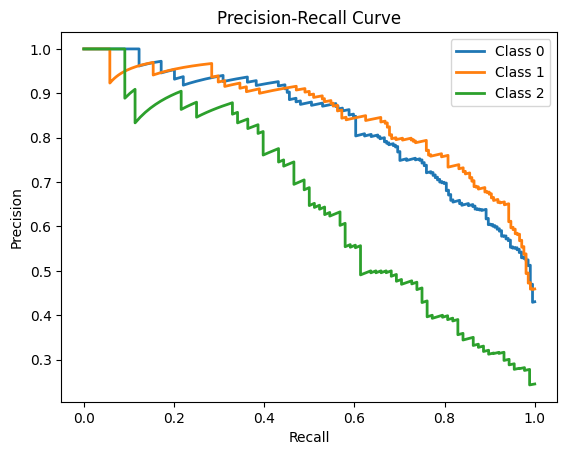

In [13]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.svm import SVC

model_svm = SVC(probability=True)

model_svm.fit(X_train, y_train)

y_prob = model_svm.predict_proba(X_test)

# Binarize labels (One-vs-Rest) untuk setiap kelas
y_test_bin = pd.get_dummies(y_test).values

# Menghitung Precision-Recall curve untuk setiap kelas
precision = dict()
recall = dict()
thresholds = dict()
for i in range(3):  
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])

    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i}')
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()


In [66]:
f1_scores = dict()
best_thresholds = dict()

for i in range(3):
    f1_scores[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
    best_index = np.argmax(f1_scores[i])
    best_thresholds[i] = thresholds[i][best_index]  # Threshold terbaik untuk kelas i
    print(f'Threshold terbaik untuk class {i}: {best_thresholds[i]}')


Threshold terbaik untuk class 0: 0.6543017347501383
Threshold terbaik untuk class 1: 0.33433946336410203
Threshold terbaik untuk class 2: 0.22608909658196708


In [67]:
y_pred_custom_threshold = []

for prob in y_prob:
    if prob[2] >= best_thresholds[2]:  
        y_pred_custom_threshold.append(2)
    elif prob[1] >= best_thresholds[1]:  
        y_pred_custom_threshold.append(1)
    elif prob[0] >= best_thresholds[0]:  
        y_pred_custom_threshold.append(0)
    else:
        # Jika tidak ada yang memenuhi threshold, pilih probabilitas tertinggi
        y_pred_custom_threshold.append(np.argmax(prob))

check_result(y_test, y_pred_custom_threshold)

Accuracy: 0.73
Precision: 0.7283952499492699
Recall: 0.73
F1 Score: 0.7286723548510188
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       204
           1       0.77      0.76      0.76       208
           2       0.63      0.57      0.60        88

    accuracy                           0.73       500
   macro avg       0.71      0.70      0.70       500
weighted avg       0.73      0.73      0.73       500



In [58]:
# # MLP Classifier
# from sklearn.neural_network import MLPClassifier

# model_mlp = MLPClassifier()
# model_mlp.fit(X_train, y_train)

# y_pred = model_mlp.predict(X_test)

# check_result(y_test, y_pred)

Accuracy: 0.68
Precision: 0.6758706137735264
Recall: 0.68
F1 Score: 0.6768789232218272
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       204
           1       0.73      0.73      0.73       208
           2       0.53      0.44      0.48        88

    accuracy                           0.68       500
   macro avg       0.65      0.63      0.64       500
weighted avg       0.68      0.68      0.68       500



In [59]:
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier

model_ada = AdaBoostClassifier()
model_ada.fit(X_train, y_train)

y_pred = model_ada.predict(X_test)

check_result(y_test, y_pred)

Accuracy: 0.584
Precision: 0.6590957628833735
Recall: 0.584
F1 Score: 0.5498847123771289
              precision    recall  f1-score   support

           0       0.51      0.85      0.64       204
           1       0.72      0.51      0.60       208
           2       0.85      0.12      0.22        88

    accuracy                           0.58       500
   macro avg       0.69      0.50      0.49       500
weighted avg       0.66      0.58      0.55       500



In [60]:
# Bagging
from sklearn.ensemble import BaggingClassifier

model_bag = BaggingClassifier()
model_bag.fit(X_train, y_train)

y_pred = model_bag.predict(X_test)

check_result(y_test, y_pred)

Accuracy: 0.572
Precision: 0.5718916526721327
Recall: 0.572
F1 Score: 0.5606882878838888
              precision    recall  f1-score   support

           0       0.52      0.67      0.58       204
           1       0.68      0.62      0.65       208
           2       0.45      0.23      0.30        88

    accuracy                           0.57       500
   macro avg       0.55      0.51      0.51       500
weighted avg       0.57      0.57      0.56       500



In [61]:
# Perceptron
from sklearn.linear_model import Perceptron

model_perceptron = Perceptron()
model_perceptron.fit(X_train, y_train)

y_pred = model_perceptron.predict(X_test)

check_result(y_test, y_pred)

Accuracy: 0.638
Precision: 0.6300877312560856
Recall: 0.638
F1 Score: 0.6287828481761502
              precision    recall  f1-score   support

           0       0.66      0.67      0.67       204
           1       0.65      0.74      0.69       208
           2       0.53      0.33      0.41        88

    accuracy                           0.64       500
   macro avg       0.61      0.58      0.59       500
weighted avg       0.63      0.64      0.63       500



In [70]:
# XGBoost
from xgboost import XGBClassifier

model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)

check_result(y_test, y_pred)

Accuracy: 0.686
Precision: 0.7233357141240636
Recall: 0.686
F1 Score: 0.6629839298872741
              precision    recall  f1-score   support

           0       0.60      0.91      0.72       204
           1       0.84      0.67      0.75       208
           2       0.73      0.22      0.33        88

    accuracy                           0.69       500
   macro avg       0.72      0.60      0.60       500
weighted avg       0.72      0.69      0.66       500

